In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

import imgaug as ia
from imgaug import augmenters as iaa
import skimage.io
import numpy as np


ia.seed(1)

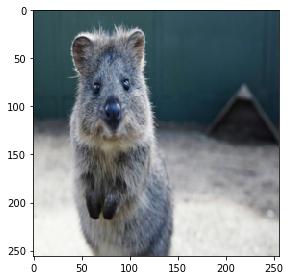

In [3]:
image = ia.quokka(size=(256, 256))
bbs = ia.BoundingBoxesOnImage([
    ia.BoundingBox(x1=65, y1=100, x2=200, y2=150),
    ia.BoundingBox(x1=150, y1=80, x2=200, y2=130)
], shape=image.shape)

skimage.io.imshow(image)

In [6]:
seq = iaa.Sequential([
    iaa.Multiply((1.2, 1.5)), # change brightness, doesn't affect BBs
    iaa.Affine(
        translate_px={"x": 40, "y": 60},
        scale=(0.5, 0.7)
    ) # translate by 40/60px on x/y axis, and scale to 50-70%, affects BBs
])


In [7]:
# Make our sequence deterministic.
# We can now apply it to the image and then to the BBs and it will
# lead to the same augmentations.
# IMPORTANT: Call this once PER BATCH, otherwise you will always get the
# exactly same augmentations for every batch!
seq_det = seq.to_deterministic()


In [8]:
# Augment BBs and images.
# As we only have one image and list of BBs, we use
# [image] and [bbs] to turn both into lists (batches) for the
# functions and then [0] to reverse that. In a real experiment, your
# variables would likely already be lists.
image_aug = seq_det.augment_images([image])[0]
bbs_aug = seq_det.augment_bounding_boxes([bbs])[0]

In [9]:
# print coordinates before/after augmentation (see below)
# use .x1_int, .y_int, ... to get integer coordinates
for i in range(len(bbs.bounding_boxes)):
    before = bbs.bounding_boxes[i]
    after = bbs_aug.bounding_boxes[i]
    print("BB %d: (%.4f, %.4f, %.4f, %.4f) -> (%.4f, %.4f, %.4f, %.4f)" % (
        i,
        before.x1, before.y1, before.x2, before.y2,
        after.x1, after.y1, after.x2, after.y2)
    )



BB 0: (65.0000, 100.0000, 200.0000, 150.0000) -> (130.7524, 171.3311, 210.1272, 200.7291)
BB 1: (150.0000, 80.0000, 200.0000, 130.0000) -> (180.7291, 159.5718, 210.1272, 188.9699)


In [10]:
# image with BBs before/after augmentation (shown below)
image_before = bbs.draw_on_image(image, thickness=2)
image_after = bbs_aug.draw_on_image(image_aug, thickness=2, color=[0, 0, 255])

In [19]:
import imgaug as ia
from imgaug import augmenters as iaa
import numpy as np

ia.seed(1)

# Example batch of images.
# The array has shape (32, 64, 64, 3) and dtype uint8.
images = np.array(
    [ia.quokka(size=(64, 64)) for _ in range(32)],
    dtype=np.uint8
)

seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Crop(percent=(0, 0.1)), # random crops
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    # Strengthen or weaken the contrast in each image.
    iaa.ContrastNormalization((0.75, 1.5)),
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    )
], random_order=True) # apply augmenters in random order

images_aug = seq.augment_images(images)

In [25]:
import matplotlib.pyplot as plt

In [26]:
from imgaug import augmenters as iaa
import numpy as np

images = np.random.randint(0, 255, (16, 128, 128, 3), dtype=np.uint8)
seq = iaa.Sequential([iaa.Fliplr(0.5), iaa.GaussianBlur((0, 3.0))])

# show an image with 8*8 augmented versions of image 0
seq.show_grid(images[0], cols=8, rows=8)

# Show an image with 8*8 augmented versions of image 0 and 8*8 augmented
# versions of image 1. The identical augmentations will be applied to
# image 0 and 1.
seq.show_grid([images[0], images[1]], cols=8, rows=8)

RuntimeError: Could not execute image viewer.

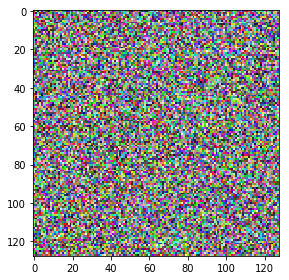

In [18]:
from scipy import misc
import skimage.io
import numpy as np
image = np.random.randint(0, 255, (128, 128, 3), dtype=np.uint8)
skimage.io.imshow(image)